In [1]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
BASE_BUFFER = 1        # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1 # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5       # minutes penalty when assigning the Loop track
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver

# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

# Parse ETA and ETD if present
if 'ETA' in df.columns:
    df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce')
else:
    df['eta'] = pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')
if 'ETD' in df.columns:
    df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce')
else:
    df['etd'] = pd.NaT

# Normalize direction
if 'direction' in df.columns:
    df['direction'] = df['direction'].astype(str).apply(
        lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top'
    )
else:
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

# dwell_time (freight = 0, others from ETD-ETA or fallback)
def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        delta = minutes_between(row['eta'], row['etd'])
        return max(1, int(delta))
    return 3

df['dwell_time'] = df.apply(compute_dwell, axis=1)

# priority
if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

# length
if 'length' not in df.columns:
    df['length'] = 200
else:
    df['length'] = df['length'].fillna(200).astype(int)

# eta_uncertainty
if 'eta_uncertainty' not in df.columns:
    if 'current_delay_s' in df.columns:
        df['eta_uncertainty'] = (df['current_delay_s'].fillna(0) / 60).clip(lower=1).astype(int)
    else:
        df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Horizon start
min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)

# Service time + buffer
def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)  # approach + dwell + exit + length
df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']

horizon = int((df['eta_min'] + df['effective_service']).max()) + 60
print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')

assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])

    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir'] == 'both' or
                  (tr_meta['dir'] == 'top2bottom' and t['direction'] == 'top2bottom') or
                  (tr_meta['dir'] == 'bottom2top' and t['direction'] == 'bottom2top'))
        if not dir_ok:
            continue

        # --- Platform requirement ---
        if str(t.get('train_type', '')).lower() == "freight":
            has_platform = True   # freight doesn't need platform
        else:
            has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        # --- enforce start >= ETA and tie delay to actual start ---
        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# ---------------------------
# Objective (soft delay penalties)
# ---------------------------
delay_terms = []
for t in trains:
    tid = t['train_id']
    dvar = delay_vars[tid]
    train_type = str(t.get('train_type', '')).lower()

    if train_type == "express":
        weight = 100
    elif train_type == "passenger":
        weight = 50
    elif train_type == "special":
        weight = 20
    elif train_type == "freight":
        weight = 10
    else:
        weight = 30  # default fallback

    delay_terms.append(dvar * weight)

# Loop penalties
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

# Final objective
model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "train_type": t.get('train_type', 'Unknown'),
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)

print("\nSchedule (sorted by planned start):")
display(sched_df.sort_values(by='planned_start_dt').head(50))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))
y_positions = {tr: i for i, tr in enumerate(tracks)}

for _, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start, dur = row['start_min'], row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']),
            va='center', ha='center', fontsize=8, color='white')

ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Save
# ---------------------------
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")

# ---------------------------
# KPIs
# ---------------------------
print("\n=== Key Performance Indicators (KPIs) ===")

# Average delay (already computed)
print(f"Average delay (minutes): {avg_delay:.2f}")

# Maximum delay
max_delay = sched_df['delay_min'].max()
print(f"Maximum delay (minutes): {max_delay}")

# Utilization per track
track_utilization = {}
for tr in TRACKS.keys():
    total_time = 0
    for _, row in sched_df[sched_df['assigned_track'] == tr].iterrows():
        if pd.notna(row['start_min']) and pd.notna(row['end_min']):
            total_time += row['end_min'] - row['start_min']
    utilization_pct = (total_time / horizon) * 100
    track_utilization[tr] = utilization_pct
    print(f"Track {tr} utilization: {utilization_pct:.2f}%")

# Summary dataframe for easier export/plotting if needed
kpi_df = pd.DataFrame([
    {"KPI": "Average Delay (min)", "Value": avg_delay},
    {"KPI": "Maximum Delay (min)", "Value": max_delay},
] + [
    {"KPI": f"Track {tr} Utilization (%)", "Value": util}
    for tr, util in track_utilization.items()
])

kpi_df.to_csv("kpi_summary.csv", index=False)
print("\nSaved KPI summary to kpi_summary.csv")
display(kpi_df)

ModuleNotFoundError: No module named 'ortools'

In [2]:
# Install OR-Tools
!pip install ortools



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatib

In [3]:
# pip installs if needed (uncomment if running in a fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration / Parameters
# ---------------------------
CSV_PATH = "./station_trains_30.csv"  # change if needed
HORIZON_MINUTES = 180  # scheduling horizon in minutes (from earliest ETA)
BASE_BUFFER = 1        # base buffer between trains on same track (minutes)
UNCERTAINTY_MARGIN = 1 # multiplier for ETA uncertainty -> buffer
LOOP_PENALTY = 5       # minutes penalty when assigning the Loop track
MAX_SOLVE_TIME_S = 30  # seconds to allow the solver

# Map tracks: directionality rules
TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}
PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Place station_trains_30.csv in notebook folder.")

df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

# Parse ETA and ETD if present
if 'ETA' in df.columns:
    df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce')
else:
    df['eta'] = pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')
if 'ETD' in df.columns:
    df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce')
else:
    df['etd'] = pd.NaT

# Normalize direction
if 'direction' in df.columns:
    df['direction'] = df['direction'].astype(str).apply(
        lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top'
    )
else:
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

# dwell_time (freight = 0, others from ETD-ETA or fallback)
def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        delta = minutes_between(row['eta'], row['etd'])
        return max(1, int(delta))
    return 3

df['dwell_time'] = df.apply(compute_dwell, axis=1)

# priority
if 'priority' not in df.columns:
    df['priority'] = 1
else:
    df['priority'] = df['priority'].fillna(1).astype(int)

# length
if 'length' not in df.columns:
    df['length'] = 200
else:
    df['length'] = df['length'].fillna(200).astype(int)

# eta_uncertainty
if 'eta_uncertainty' not in df.columns:
    if 'current_delay_s' in df.columns:
        df['eta_uncertainty'] = (df['current_delay_s'].fillna(0) / 60).clip(lower=1).astype(int)
    else:
        df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

# Horizon start
min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)

# Service time + buffer
def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)  # approach + dwell + exit + length
df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']

horizon = int((df['eta_min'] + df['effective_service']).max()) + 60
print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')

assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])

    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir'] == 'both' or
                  (tr_meta['dir'] == 'top2bottom' and t['direction'] == 'top2bottom') or
                  (tr_meta['dir'] == 'bottom2top' and t['direction'] == 'bottom2top'))
        if not dir_ok:
            continue

        # --- Platform requirement ---
        if str(t.get('train_type', '')).lower() == "freight":
            has_platform = True   # freight doesn't need platform
        else:
            has_platform = any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        # --- enforce start >= ETA and tie delay to actual start ---
        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# ---------------------------
# Objective (soft delay penalties)
# ---------------------------
delay_terms = []
for t in trains:
    tid = t['train_id']
    dvar = delay_vars[tid]
    train_type = str(t.get('train_type', '')).lower()

    if train_type == "express":
        weight = 100
    elif train_type == "passenger":
        weight = 50
    elif train_type == "special":
        weight = 20
    elif train_type == "freight":
        weight = 10
    else:
        weight = 30  # default fallback

    delay_terms.append(dvar * weight)

# Loop penalties
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

# Final objective
model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving (this may take a few seconds)...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "train_type": t.get('train_type', 'Unknown'),
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(
    lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)

print("\nSchedule (sorted by planned start):")
display(sched_df.sort_values(by='planned_start_dt').head(50))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}

fig, ax = plt.subplots(figsize=(14, 6))
y_positions = {tr: i for i, tr in enumerate(tracks)}

for _, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start, dur = row['start_min'], row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']),
            va='center', ha='center', fontsize=8, color='white')

ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)

patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Save
# ---------------------------
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")

# ---------------------------
# KPIs
# ---------------------------
print("\n=== Key Performance Indicators (KPIs) ===")

# Average delay (already computed)
print(f"Average delay (minutes): {avg_delay:.2f}")

# Maximum delay
max_delay = sched_df['delay_min'].max()
print(f"Maximum delay (minutes): {max_delay}")

# Utilization per track
track_utilization = {}
for tr in TRACKS.keys():
    total_time = 0
    for _, row in sched_df[sched_df['assigned_track'] == tr].iterrows():
        if pd.notna(row['start_min']) and pd.notna(row['end_min']):
            total_time += row['end_min'] - row['start_min']
    utilization_pct = (total_time / horizon) * 100
    track_utilization[tr] = utilization_pct
    print(f"Track {tr} utilization: {utilization_pct:.2f}%")

# Summary dataframe for easier export/plotting if needed
kpi_df = pd.DataFrame([
    {"KPI": "Average Delay (min)", "Value": avg_delay},
    {"KPI": "Maximum Delay (min)", "Value": max_delay},
] + [
    {"KPI": f"Track {tr} Utilization (%)", "Value": util}
    for tr, util in track_utilization.items()
])

kpi_df.to_csv("kpi_summary.csv", index=False)
print("\nSaved KPI summary to kpi_summary.csv")
display(kpi_df)

FileNotFoundError: CSV not found at ./station_trains_30.csv. Place station_trains_30.csv in notebook folder.

In [4]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()


Saving station_trains_30.csv to station_trains_30.csv


Please upload your CSV file (e.g., station_trains_30.csv):


Saving station_trains_30.csv to station_trains_30 (1).csv
Dataset preview:


,train_id,ETA,ETD,train_type,priority,current_delay_s,direction
0,T001,2025-09-15T10:01:27Z,2025-09-15T10:07:36Z,Freight,3,120,TOP
1,T002,2025-09-15T10:04:21Z,2025-09-15T10:07:48Z,Passenger,6,0,TOP
2,T003,2025-09-15T10:05:23Z,2025-09-15T10:08:40Z,Passenger,6,30,TOP
3,T004,2025-09-15T10:06:55Z,2025-09-15T10:09:19Z,Express,10,0,TOP
4,T005,2025-09-15T10:08:01Z,2025-09-15T10:10:45Z,Special,5,120,TOP


Scheduling horizon start: 2025-09-15 09:56:22+00:00  horizon (min): 104 minutes
Solving...
Solver status: FEASIBLE

Schedule preview:


,train_id,train_type,direction,assigned_track,start_min,end_min,eta_min,delay_min,priority,service_time,planned_start_dt,planned_end_dt
0,T001,Freight,top2bottom,D,5,12,5,0,3,4,2025-09-15 10:01:22+00:00,2025-09-15 10:08:22+00:00
15,T016,Special,bottom2top,B,5,13,5,0,5,6,2025-09-15 10:01:22+00:00,2025-09-15 10:09:22+00:00
1,T002,Passenger,top2bottom,C,7,16,7,0,6,7,2025-09-15 10:03:22+00:00,2025-09-15 10:12:22+00:00
2,T003,Passenger,top2bottom,A,9,18,9,0,6,7,2025-09-15 10:05:22+00:00,2025-09-15 10:14:22+00:00
17,T018,Passenger,bottom2top,E,9,19,9,0,6,7,2025-09-15 10:05:22+00:00,2025-09-15 10:15:22+00:00
3,T004,Express,top2bottom,Loop,10,18,10,0,10,6,2025-09-15 10:06:22+00:00,2025-09-15 10:14:22+00:00
18,T019,Special,bottom2top,D,12,20,11,1,5,6,2025-09-15 10:08:22+00:00,2025-09-15 10:16:22+00:00
4,T005,Special,top2bottom,B,13,22,11,2,5,6,2025-09-15 10:09:22+00:00,2025-09-15 10:18:22+00:00
6,T007,Express,top2bottom,C,16,23,16,0,10,5,2025-09-15 10:12:22+00:00,2025-09-15 10:19:22+00:00
7,T008,Express,top2bottom,A,18,25,17,1,10,5,2025-09-15 10:14:22+00:00,2025-09-15 10:21:22+00:00


Average delay (minutes): 5.43
Gantt chart saved as gantt_schedule.png


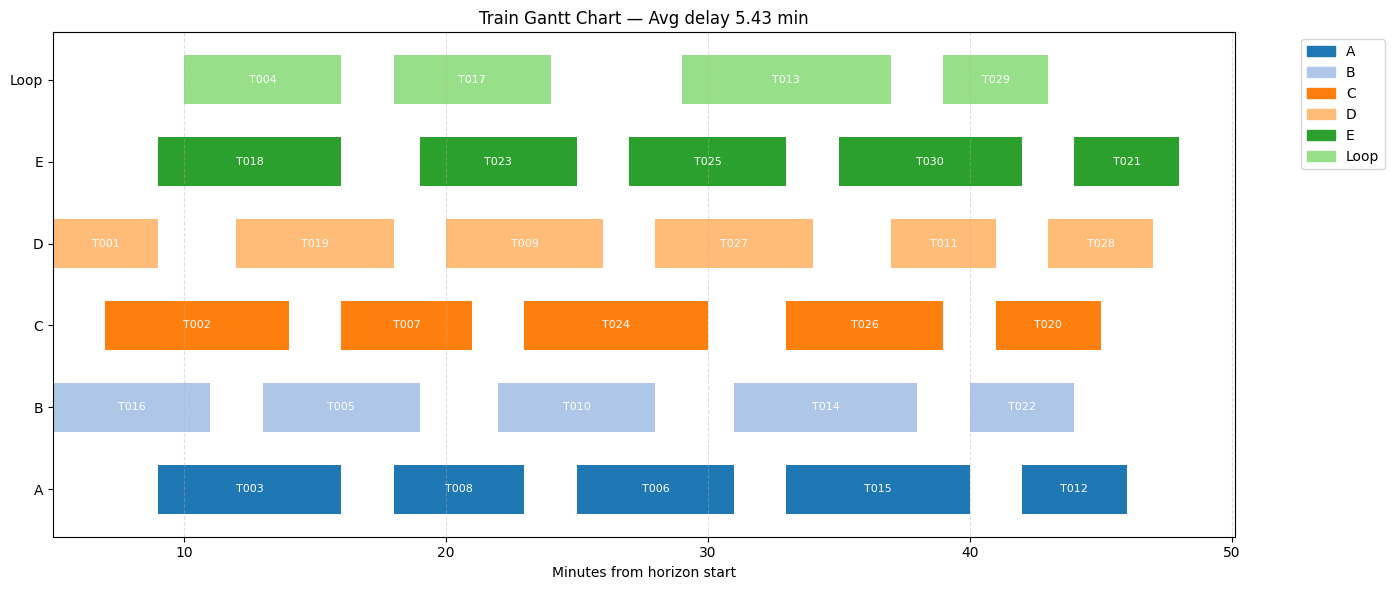

Saved detailed schedule to scheduled_output.csv

=== Key Performance Indicators (KPIs) ===
Average delay (minutes): 5.43
Maximum delay (minutes): 28
Track A utilization: 37.50%
Track B utilization: 39.42%
Track C utilization: 38.46%
Track D utilization: 43.27%
Track E utilization: 40.38%
Track Loop utilization: 30.77%
Saved KPI summary to kpi_summary.csv


,KPI,Value
0,Average Delay (min),5.433333
1,Maximum Delay (min),28.000000
2,Track A Utilization (%),37.500000
3,Track B Utilization (%),39.423077
4,Track C Utilization (%),38.461538
5,Track D Utilization (%),43.269231
6,Track E Utilization (%),40.384615
7,Track Loop Utilization (%),30.769231


In [5]:
# ---------------------------
# Colab-ready Train Scheduler
# ---------------------------

# Install dependencies (uncomment if running fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
from google.colab import files

# ---------------------------
# Upload CSV
# ---------------------------
print("Please upload your CSV file (e.g., station_trains_30.csv):")
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

# ---------------------------
# Configuration / Parameters
# ---------------------------
HORIZON_MINUTES = 180
BASE_BUFFER = 1
UNCERTAINTY_MARGIN = 1
LOOP_PENALTY = 5
MAX_SOLVE_TIME_S = 30

TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}

PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

if 'ETA' in df.columns:
    df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce')
else:
    df['eta'] = pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')

if 'ETD' in df.columns:
    df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce')
else:
    df['etd'] = pd.NaT

if 'direction' in df.columns:
    df['direction'] = df['direction'].astype(str).apply(
        lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top'
    )
else:
    df['direction'] = ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]

def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        delta = minutes_between(row['eta'], row['etd'])
        return max(1, int(delta))
    return 3

df['dwell_time'] = df.apply(compute_dwell, axis=1)

df['priority'] = df.get('priority', pd.Series([1]*len(df))).fillna(1).astype(int)
df['length'] = df.get('length', pd.Series([200]*len(df))).fillna(200).astype(int)
if 'eta_uncertainty' not in df.columns:
    if 'current_delay_s' in df.columns:
        df['eta_uncertainty'] = (df['current_delay_s'].fillna(0) / 60).clip(lower=1).astype(int)
    else:
        df['eta_uncertainty'] = 1
else:
    df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int)

min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)

def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)

df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']

horizon = int((df['eta_min'] + df['effective_service']).max()) + 60
print(f"Scheduling horizon start: {horizon_start}  horizon (min): {horizon} minutes")

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')

assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])
    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir'] == 'both' or
                  (tr_meta['dir'] == 'top2bottom' and t['direction'] == 'top2bottom') or
                  (tr_meta['dir'] == 'bottom2top' and t['direction'] == 'bottom2top'))
        if not dir_ok:
            continue

        has_platform = True if str(t.get('train_type', '')).lower() == "freight" else \
                       any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# ---------------------------
# Objective
# ---------------------------
delay_terms = []
for t in trains:
    tid = t['train_id']
    dvar = delay_vars[tid]
    train_type = str(t.get('train_type', '')).lower()
    weight = {"express":100, "passenger":50, "special":20, "freight":10}.get(train_type,30)
    delay_terms.append(dvar * weight)

loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

model.Minimize(sum(delay_terms) + sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL", "FEASIBLE"):
    raise RuntimeError("Solver did not return a feasible solution.")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid,
        "train_type": t.get('train_type', 'Unknown'),
        "direction": t['direction'],
        "assigned_track": chosen_track_name,
        "start_min": chosen_s,
        "end_min": chosen_e,
        "eta_min": int(t['eta_min']),
        "delay_min": int(delay_minutes),
        "priority": int(t['priority']),
        "service_time": int(t['service_time']),
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)

print("\nSchedule preview:")
display(sched_df.sort_values(by='planned_start_dt').head(20))

avg_delay = sched_df['delay_min'].mean()
print(f"Average delay (minutes): {avg_delay:.2f}")

# ---------------------------
# Gantt chart
# ---------------------------
tracks = sorted(set(sched_df['assigned_track']))
color_map = {tr: plt.cm.tab20(i % 20) for i, tr in enumerate(tracks)}
fig, ax = plt.subplots(figsize=(14, 6))
y_positions = {tr: i for i, tr in enumerate(tracks)}

for _, row in sched_df.iterrows():
    tr = row['assigned_track']
    if tr == "UNASSIGNED" or pd.isna(row['start_min']):
        continue
    start, dur = row['start_min'], row['service_time']
    ax.barh(y_positions[tr], dur, left=start, height=0.6, align='center', color=color_map[tr])
    ax.text(start + dur/2, y_positions[tr], str(row['train_id']), va='center', ha='center', fontsize=8, color='white')

ax.set_yticks([y_positions[t] for t in tracks])
ax.set_yticklabels(tracks)
ax.set_xlabel("Minutes from horizon start")
ax.set_title(f"Train Gantt Chart — Avg delay {avg_delay:.2f} min")
ax.grid(axis='x', linestyle='--', alpha=0.4)
patches = [mpatches.Patch(color=color_map[t], label=t) for t in tracks]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("gantt_schedule.png", dpi=150)
print("Gantt chart saved as gantt_schedule.png")
plt.show()

# ---------------------------
# Save CSV
# ---------------------------
sched_df.to_csv("scheduled_output.csv", index=False)
print("Saved detailed schedule to scheduled_output.csv")

# ---------------------------
# KPIs
# ---------------------------
print("\n=== Key Performance Indicators (KPIs) ===")
max_delay = sched_df['delay_min'].max()
print(f"Average delay (minutes): {avg_delay:.2f}")
print(f"Maximum delay (minutes): {max_delay}")

track_utilization = {}
for tr in TRACKS.keys():
    total_time = sched_df[sched_df['assigned_track'] == tr].apply(lambda r: r['end_min']-r['start_min'] if pd.notna(r['start_min']) else 0, axis=1).sum()
    utilization_pct = (total_time / horizon) * 100
    track_utilization[tr] = utilization_pct
    print(f"Track {tr} utilization: {utilization_pct:.2f}%")

# Summary
kpi_df = pd.DataFrame([{"KPI": "Average Delay (min)", "Value": avg_delay},
                       {"KPI": "Maximum Delay (min)", "Value": max_delay}] +
                      [{"KPI": f"Track {tr} Utilization (%)", "Value": util} for tr, util in track_utilization.items()])
kpi_df.to_csv("kpi_summary.csv", index=False)
print("Saved KPI summary to kpi_summary.csv")
display(kpi_df)


In [6]:
# ---------------------------
# Colab-ready Train Scheduler + What-If + FCFS
# ---------------------------

# Install dependencies (uncomment if running fresh environment)
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
from google.colab import files

# ---------------------------
# Upload CSV
# ---------------------------
print("Please upload your CSV file (e.g., station_trains_30.csv):")
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

# ---------------------------
# Configuration / Parameters
# ---------------------------
HORIZON_MINUTES = 180
BASE_BUFFER = 1
UNCERTAINTY_MARGIN = 1
LOOP_PENALTY = 5
MAX_SOLVE_TIME_S = 30

TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},  # platform D will have maintenance
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}

PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        delta = minutes_between(row['eta'], row['etd'])
        return max(1, int(delta))
    return 3

def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor * 1)

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(CSV_PATH)
if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)

df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce') if 'ETA' in df.columns else pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')
df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce') if 'ETD' in df.columns else pd.NaT

df['direction'] = df['direction'].astype(str).apply(lambda x: 'top2bottom' if str(x).strip().upper().startswith('TOP') else 'bottom2top') if 'direction' in df.columns else ['top2bottom' if i % 2 == 0 else 'bottom2top' for i in range(len(df))]
df['dwell_time'] = df.apply(compute_dwell, axis=1)
df['priority'] = df.get('priority', pd.Series([1]*len(df))).fillna(1).astype(int)
df['length'] = df.get('length', pd.Series([200]*len(df))).fillna(200).astype(int)
df['eta_uncertainty'] = df.get('eta_uncertainty', 1)
min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)
df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']
horizon = int((df['eta_min'] + df['effective_service']).max()) + 60

# ---------------------------
# What-if: Platform D maintenance
# ---------------------------
# Close platform D from 30 to 50 minutes
platform_closure = {"D": [(30, 50)]}  # (start_min, end_min)

# Function to check if platform is open at time
def is_platform_open(platform, start, end):
    if platform not in platform_closure:
        return True
    for (c_start, c_end) in platform_closure[platform]:
        if start < c_end and end > c_start:
            return False
    return True

# ---------------------------
# Build CP-SAT model with closure
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')
assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])
    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar

    track_option_binaries = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir'] == 'both' or
                  (tr_meta['dir'] == 'top2bottom' and t['direction'] == 'top2bottom') or
                  (tr_meta['dir'] == 'bottom2top' and t['direction'] == 'bottom2top'))
        if not dir_ok:
            continue

        has_platform = True if str(t.get('train_type', '')).lower() == "freight" else \
                       any(PLATFORMS[p]['status'] == 'open' and PLATFORMS[p]['length'] >= t['length'] for p in PLATFORMS)
        if not has_platform:
            continue

        # Skip platform if closed during what-if window
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        # Constraint: platform open
        if tr_id in platform_closure:
            for (c_start, c_end) in platform_closure[tr_id]:
                # Optional interval cannot overlap closure
                model.AddNoOverlap([ivar, model.NewIntervalVar(c_start, c_end - c_start, c_end, model.NewConstant(True))])

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# Objective: same as before
delay_terms = [delay_vars[t['train_id']] * {"express":100, "passenger":50, "special":20, "freight":10}.get(str(t.get('train_type','')).lower(),30) for t in trains]
loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr == "Loop":
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen == LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen == 0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)
model.Minimize(sum(delay_terms)+sum(loop_penalty_terms))

# Solve
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8
res = solver.Solve(model)
print("Solver status:", solver.StatusName(res))

# Extract solution
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key = (tid, tr_id)
        if key in assign_vars and solver.Value(assign_vars[key]) == 1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    schedule.append({"train_id":tid,"assigned_track":chosen_track_name,"start_min":chosen_s,"end_min":chosen_e,"delay_min":solver.Value(delay_vars[tid])})
sched_df = pd.DataFrame(schedule)

# ---------------------------
# FCFS baseline (manual operator)
# ---------------------------
fcfs_schedule = []
platform_times = {p:0 for p in PLATFORMS}
for _, row in df.sort_values(by='eta_min').iterrows():
    assigned = False
    for p in PLATFORMS:
        start_time = max(row['eta_min'], platform_times[p])
        # Skip platform D if closed
        if p in platform_closure and any(start_time < c_end and start_time + row['service_time'] > c_start for c_start, c_end in platform_closure[p]):
            continue
        fcfs_schedule.append({"train_id":row['train_id'],"assigned_platform":p,"start_min":start_time,"end_min":start_time+row['service_time']})
        platform_times[p] = start_time + row['service_time']
        assigned = True
        break
    if not assigned:
        fcfs_schedule.append({"train_id":row['train_id'],"assigned_platform":"UNASSIGNED","start_min":None,"end_min":None})
fcfs_df = pd.DataFrame(fcfs_schedule)

print("\n--- FCFS baseline schedule ---")
display(fcfs_df.head(20))


Please upload your CSV file (e.g., station_trains_30.csv):


Saving station_trains_30.csv to station_trains_30 (2).csv


NotImplementedError: Evaluating a Literal as a Boolean valueis not supported.

Dataset preview:


,train_id,ETA,ETD,train_type,priority,current_delay_s,direction
0,T001,2025-09-15T10:01:27Z,2025-09-15T10:07:36Z,Freight,3,120,TOP
1,T002,2025-09-15T10:04:21Z,2025-09-15T10:07:48Z,Passenger,6,0,TOP
2,T003,2025-09-15T10:05:23Z,2025-09-15T10:08:40Z,Passenger,6,30,TOP
3,T004,2025-09-15T10:06:55Z,2025-09-15T10:09:19Z,Express,10,0,TOP
4,T005,2025-09-15T10:08:01Z,2025-09-15T10:10:45Z,Special,5,120,TOP


Horizon: 104 minutes
Solving...
Solver status: FEASIBLE
FCFS Schedule after full closure handling:


,train_id,assigned_track,start_min,end_min,delay_min,planned_start_dt,planned_end_dt
0,T001,A,5,11,0,2025-09-15 10:01:22+00:00,2025-09-15 10:07:22+00:00
1,T016,B,5,13,0,2025-09-15 10:01:22+00:00,2025-09-15 10:09:22+00:00
2,T002,C,7,16,0,2025-09-15 10:03:22+00:00,2025-09-15 10:12:22+00:00
3,T017,D,8,16,0,2025-09-15 10:04:22+00:00,2025-09-15 10:12:22+00:00
4,T018,E,9,18,0,2025-09-15 10:05:22+00:00,2025-09-15 10:14:22+00:00
5,T003,Loop,9,18,0,2025-09-15 10:05:22+00:00,2025-09-15 10:14:22+00:00
6,T004,A,11,19,1,2025-09-15 10:07:22+00:00,2025-09-15 10:15:22+00:00
7,T005,B,13,21,2,2025-09-15 10:09:22+00:00,2025-09-15 10:17:22+00:00
8,T019,C,16,24,5,2025-09-15 10:12:22+00:00,2025-09-15 10:20:22+00:00
9,T006,D,16,24,3,2025-09-15 10:12:22+00:00,2025-09-15 10:20:22+00:00


FCFS Average delay: 4.70 min


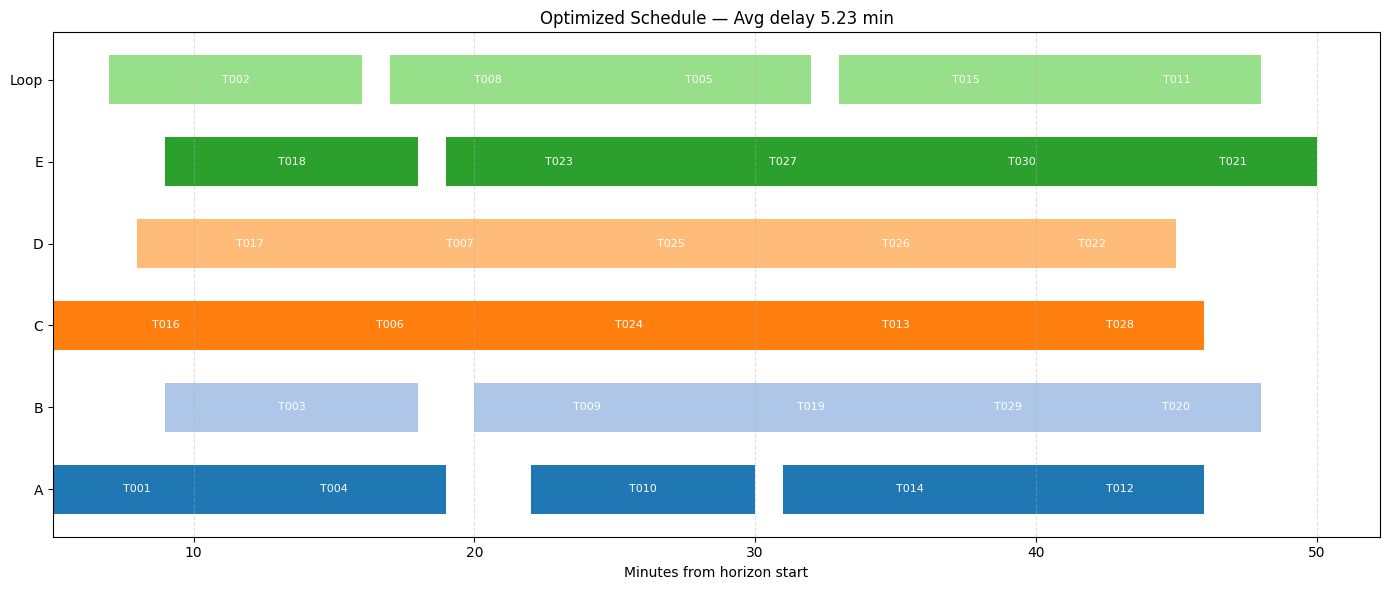

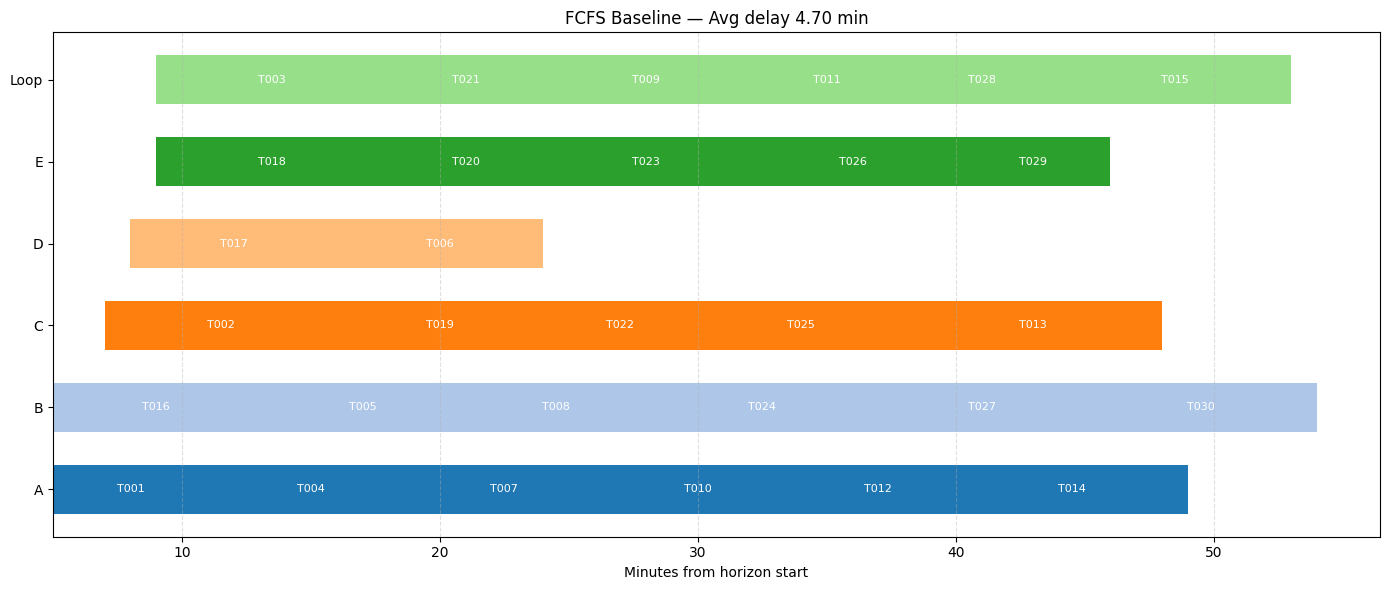

In [2]:
# ---------------------------
# pip installs if needed
# ---------------------------
# !pip install ortools pandas matplotlib

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ortools.sat.python import cp_model
import math
import os

# ---------------------------
# Configuration
# ---------------------------
  # Update if needed
CSV_PATH = "./station_trains_30.csv"
HORIZON_MINUTES = 180
BASE_BUFFER = 1
UNCERTAINTY_MARGIN = 1
LOOP_PENALTY = 5
MAX_SOLVE_TIME_S = 30

TRACKS = {
    "A": {"dir": "top2bottom", "capacity": 1},
    "B": {"dir": "both", "capacity": 1},
    "C": {"dir": "both", "capacity": 1},
    "D": {"dir": "both", "capacity": 1},
    "E": {"dir": "bottom2top", "capacity": 1},
    "Loop": {"dir": "both", "capacity": 1, "is_loop": True},
}

PLATFORMS = {
    "P1": {"length": 1000, "status": "open"},
    "P2": {"length": 1000, "status": "open"},
    "P3": {"length": 1000, "status": "open"},
    "P4": {"length": 1000, "status": "open"},
    "P5": {"length": 1000, "status": "open"},
}

# ---------------------------
# Helper functions
# ---------------------------
def minutes_between(a, b):
    return int((b - a).total_seconds() // 60)

def compute_dwell(row):
    if str(row.get('train_type', '')).lower() == "freight":
        return 0
    if pd.notnull(row.get('etd')) and pd.notnull(row.get('eta')):
        return max(1, minutes_between(row['eta'], row['etd']))
    return 3

def estimate_service_time(row):
    length_factor = math.ceil(row['length'] / 300)
    return int(2 + row['dwell_time'] + 1 + length_factor)

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(CSV_PATH)
print("Dataset preview:")
display(df.head())

if 'train_id' not in df.columns:
    df['train_id'] = df.index.astype(str)
df['eta'] = pd.to_datetime(df['ETA'], utc=True, errors='coerce') if 'ETA' in df.columns else pd.Timestamp.now(tz='UTC') + pd.to_timedelta(range(len(df)), unit='m')
df['etd'] = pd.to_datetime(df['ETD'], utc=True, errors='coerce') if 'ETD' in df.columns else pd.NaT
df['direction'] = df['direction'].astype(str).apply(lambda x: 'top2bottom' if str(x).upper().startswith('TOP') else 'bottom2top') if 'direction' in df.columns else ['top2bottom' if i%2==0 else 'bottom2top' for i in range(len(df))]
df['dwell_time'] = df.apply(compute_dwell, axis=1)
df['priority'] = df['priority'].fillna(1).astype(int) if 'priority' in df.columns else 1
df['length'] = df['length'].fillna(200).astype(int) if 'length' in df.columns else 200
df['eta_uncertainty'] = df['eta_uncertainty'].fillna(1).astype(int) if 'eta_uncertainty' in df.columns else 1

min_eta = df['eta'].min()
horizon_start = min_eta - pd.Timedelta(minutes=5)
df['eta_min'] = ((df['eta'] - horizon_start).dt.total_seconds() // 60).astype(int)
df['service_time'] = df.apply(estimate_service_time, axis=1)
df['buffer'] = BASE_BUFFER + UNCERTAINTY_MARGIN * df['eta_uncertainty']
df['effective_service'] = df['service_time'] + df['buffer']
horizon = int((df['eta_min'] + df['effective_service']).max()) + 60
print(f"Horizon: {horizon} minutes")

# ---------------------------
# What-if simulation: platform D maintenance
# ---------------------------
platform_closure = {"D": [(30, 50)]}  # closed from 30 to 50 min

# ---------------------------
# Build CP-SAT model
# ---------------------------
model = cp_model.CpModel()
trains = df.to_dict('records')

assign_vars, start_vars, end_vars, interval_vars = {}, {}, {}, {}
delay_vars, chosen_start = {}, {}
track_intervals = {t: [] for t in TRACKS.keys()}

for t in trains:
    tid = t['train_id']
    eta_min = int(t['eta_min'])
    service = int(t['effective_service'])

    dvar = model.NewIntVar(0, horizon, f"delay_{tid}")
    delay_vars[tid] = dvar
    svar = model.NewIntVar(0, horizon, f"start_chosen_{tid}")
    chosen_start[tid] = svar
    track_option_binaries = []

    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir']=='both') or (tr_meta['dir']=='top2bottom' and t['direction']=='top2bottom') or (tr_meta['dir']=='bottom2top' and t['direction']=='bottom2top')
        if not dir_ok: continue
        has_platform = True if str(t.get('train_type','')).lower()=='freight' else any(PLATFORMS[p]['status']=='open' and PLATFORMS[p]['length']>=t['length'] for p in PLATFORMS)
        if not has_platform: continue

        binvar = model.NewBoolVar(f"assign_{tid}_{tr_id}")
        start_var = model.NewIntVar(0, horizon, f"start_{tid}_{tr_id}")
        end_var = model.NewIntVar(0, horizon, f"end_{tid}_{tr_id}")
        ivar = model.NewOptionalIntervalVar(start_var, service, end_var, binvar, f"interval_{tid}_{tr_id}")

        assign_vars[(tid, tr_id)] = binvar
        start_vars[(tid, tr_id)] = start_var
        end_vars[(tid, tr_id)] = end_var
        interval_vars[(tid, tr_id)] = ivar
        track_intervals[tr_id].append(ivar)
        track_option_binaries.append(binvar)

        # enforce start >= ETA and tie delay
        model.Add(start_var >= eta_min).OnlyEnforceIf(binvar)
        model.Add(dvar == start_var - eta_min).OnlyEnforceIf(binvar)
        model.Add(svar == start_var).OnlyEnforceIf(binvar)

        # ---------------------------
        # Platform maintenance constraint
        # ---------------------------
        # if tr_id in platform_closure:
        #     for (c_start, c_end) in platform_closure[tr_id]:
        #         model.Add(start_var >= c_end).OnlyEnforceIf(binvar)
        #         model.Add(end_var <= c_start).OnlyEnforceIf(binvar)

    if not track_option_binaries:
        raise RuntimeError(f"No feasible track for train {tid}.")
    model.Add(sum(track_option_binaries) == 1)

# No overlap for intervals
for tr_id, ivars in track_intervals.items():
    if ivars:
        model.AddNoOverlap(ivars)

# ---------------------------
# Objective: minimize weighted delays + loop penalties
# ---------------------------
delay_terms = []
for t in trains:
    tid = t['train_id']
    dvar = delay_vars[tid]
    ttype = str(t.get('train_type','')).lower()
    weight = 100 if ttype=='express' else 50 if ttype=='passenger' else 20 if ttype=='special' else 10 if ttype=='freight' else 30
    delay_terms.append(dvar*weight)

loop_penalty_terms = []
for (tid, tr), b in assign_vars.items():
    if tr=='Loop':
        pen = model.NewIntVar(0, LOOP_PENALTY, f"loop_pen_{tid}")
        model.Add(pen==LOOP_PENALTY).OnlyEnforceIf(b)
        model.Add(pen==0).OnlyEnforceIf(b.Not())
        loop_penalty_terms.append(pen)

model.Minimize(sum(delay_terms)+sum(loop_penalty_terms))

# ---------------------------
# Solve
# ---------------------------
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = MAX_SOLVE_TIME_S
solver.parameters.num_search_workers = 8

print("Solving...")
res = solver.Solve(model)
status = solver.StatusName(res)
print("Solver status:", status)
if status not in ("OPTIMAL","FEASIBLE"):
    raise RuntimeError("No feasible solution found")

# ---------------------------
# Extract solution
# ---------------------------
schedule = []
for t in trains:
    tid = t['train_id']
    chosen_track_name, chosen_s, chosen_e = "UNASSIGNED", None, None
    for tr_id in TRACKS.keys():
        key=(tid,tr_id)
        if key in assign_vars and solver.Value(assign_vars[key])==1:
            chosen_track_name = tr_id
            chosen_s = solver.Value(start_vars[key])
            chosen_e = solver.Value(end_vars[key])
            break
    delay_minutes = solver.Value(delay_vars[tid])
    schedule.append({
        "train_id": tid, "train_type": t.get('train_type','Unknown'), "direction":t['direction'],
        "assigned_track":chosen_track_name, "start_min":chosen_s, "end_min":chosen_e,
        "eta_min":int(t['eta_min']), "delay_min":int(delay_minutes),
        "priority":int(t['priority']), "service_time":int(t['service_time'])
    })

sched_df = pd.DataFrame(schedule)
sched_df['planned_start_dt'] = sched_df['start_min'].apply(lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)
sched_df['planned_end_dt'] = sched_df['end_min'].apply(lambda m: (horizon_start + pd.Timedelta(minutes=int(m))).to_pydatetime() if pd.notna(m) else None)

# ---------------------------
# FCFS baseline (manual operator)
# ---------------------------
# ---------------------------
# FCFS baseline (manual operator) – fixed
# ---------------------------
# ---------------------------
# FCFS baseline with constraints & what-if platform closure
# ---------------------------
# ---------------------------
# Robust FCFS baseline
# ---------------------------
# ---------------------------
# Robust FCFS baseline with full closure handling
# ---------------------------
fcfs_df = df.sort_values(by='eta_min').copy()
fcfs_schedule = []

track_next_free = {tr: 0 for tr in TRACKS.keys()}
platform_closure = {"D": [(30, 50)]}  # what-if

for idx, row in fcfs_df.iterrows():
    eligible_tracks = []
    for tr_id, tr_meta in TRACKS.items():
        dir_ok = (tr_meta['dir']=='both') or (tr_meta['dir']=='top2bottom' and row['direction']=='top2bottom') or (tr_meta['dir']=='bottom2top' and row['direction']=='bottom2top')
        if not dir_ok: continue
        if str(row.get('train_type','')).lower() != "freight":
            has_platform = any(PLATFORMS[p]['status']=='open' and PLATFORMS[p]['length']>=row['length'] for p in PLATFORMS)
        else:
            has_platform = True
        if has_platform:
            eligible_tracks.append(tr_id)
    if not eligible_tracks:
        raise RuntimeError(f"No eligible track for train {row['train_id']}")

    # Find earliest track considering closures
    earliest_start = None
    assigned_tr = None
    for tr in eligible_tracks:
        candidate_start = max(row['eta_min'], track_next_free[tr])
        candidate_end = candidate_start + row['effective_service']

        # Repeatedly check closures
        if tr in platform_closure:
            for (c_start, c_end) in platform_closure[tr]:
                while (candidate_start < c_end and candidate_end > c_start):
                    candidate_start = c_end
                    candidate_end = candidate_start + row['effective_service']

        if earliest_start is None or candidate_start < earliest_start:
            earliest_start = candidate_start
            assigned_tr = tr

    start_min = earliest_start
    end_min = start_min + row['effective_service']
    track_next_free[assigned_tr] = end_min
    delay_min = start_min - row['eta_min']

    fcfs_schedule.append({
        "train_id": row['train_id'],
        "assigned_track": assigned_tr,
        "start_min": start_min,
        "end_min": end_min,
        "delay_min": delay_min
    })

fcfs_df = pd.DataFrame(fcfs_schedule)
fcfs_df['planned_start_dt'] = fcfs_df['start_min'].apply(lambda m: horizon_start + pd.Timedelta(minutes=int(m)))
fcfs_df['planned_end_dt'] = fcfs_df['end_min'].apply(lambda m: horizon_start + pd.Timedelta(minutes=int(m)))
print("FCFS Schedule after full closure handling:")
display(fcfs_df.sort_values('planned_start_dt'))
print(f"FCFS Average delay: {fcfs_df['delay_min'].mean():.2f} min")


# ---------------------------
# Gantt chart: Optimized vs FCFS
# ---------------------------
def plot_gantt(df, title):
    tracks = sorted(set(df['assigned_track']))
    color_map = {tr: plt.cm.tab20(i%20) for i,tr in enumerate(tracks)}
    fig, ax = plt.subplots(figsize=(14,6))
    y_pos = {tr:i for i,tr in enumerate(tracks)}
    for _, r in df.iterrows():
        tr = r['assigned_track']
        ax.barh(y_pos[tr], r['end_min']-r['start_min'], left=r['start_min'], height=0.6, color=color_map[tr])
        ax.text(r['start_min'] + (r['end_min']-r['start_min'])/2, y_pos[tr], str(r['train_id']), va='center', ha='center', fontsize=8, color='white')
    ax.set_yticks([y_pos[t] for t in tracks])
    ax.set_yticklabels(tracks)
    ax.set_xlabel("Minutes from horizon start")
    ax.set_title(title)
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_gantt(sched_df, f"Optimized Schedule — Avg delay {sched_df['delay_min'].mean():.2f} min")
plot_gantt(fcfs_df, f"FCFS Baseline — Avg delay {fcfs_df['delay_min'].mean():.2f} min")
